# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 47.08 KiB | 7.85 MiB/s, done.


In [2]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

We will create a character level language model here ,
Tokenize means : we have to create numeric representation for our characters

In [3]:
import tensorflow as tf

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters=r'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
    split='\n',
    char_level=True
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index = tokenizer.word_index #creating character to index dictionary
index_to_char = dict((v,k) for k,v in char_to_index.items())
print(index_to_char)

{1: '\t', 2: '\n', 3: 'a', 4: 'e', 5: 'r', 6: 'o', 7: 'n', 8: 'i', 9: ' ', 10: 't', 11: 's', 12: 'l', 13: 'm', 14: 'h', 15: 'd', 16: 'c', 17: 'u', 18: 'g', 19: 'k', 20: 'b', 21: 'p', 22: 'y', 23: 'w', 24: 'f', 25: 'v', 26: 'j', 27: 'z', 28: 'x', 29: 'q'}


## Task 3

1. Converting between names and sequences ie superhero names in our dataset to numbers

In [7]:
names=data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [8]:
tokenizer.texts_to_sequences(names[0])


[[26], [17], [13], [21], [3], [1]]

In [9]:
#create simple helper function
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]




In [10]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!=0])

In [11]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [12]:
sequences=[]
for name in names:
  seq=name_to_seq(name)
  if len(seq)>=2:
    sequences+=[seq[:i] for i in range(2,len(seq)+1)]

In [13]:
sequences[:10]

[[26, 17],
 [26, 17, 13],
 [26, 17, 13, 21],
 [26, 17, 13, 21, 3],
 [26, 17, 13, 21, 3, 1],
 [15, 6],
 [15, 6, 16],
 [15, 6, 16, 10],
 [15, 6, 16, 10, 6],
 [15, 6, 16, 10, 6, 5]]

In [14]:
max_len=max([len(x) for x in sequences])
print(max_len)

33


In [15]:
padded_sequences=tf.keras.preprocessing.sequence.pad_sequences(
    sequences,padding='pre',maxlen=max_len)

In [16]:
print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 26 17]


In [17]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [18]:
x,y=padded_sequences[:,:-1],padded_sequences[:,-1]
print(x.shape,y.shape)

(88279, 32) (88279,)


In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [20]:
num_chars=len(char_to_index.keys())+1
print(num_chars)

30


## Task 6: Creating the Model

In [21]:
from numpy import tanh
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPool1D,LSTM
from tensorflow.keras.layers import Bidirectional,Dense
model=Sequential([
                  Embedding(num_chars,8),Conv1D(64,5,strides=1,activation='tanh',padding='causal'),MaxPool1D(2),LSTM(32),Dense(num_chars,activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 7: Training the Model

In [22]:
h=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])
#

Epoch 1/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.1559 - loss: 2.8791 - val_accuracy: 0.2200 - val_loss: 2.5935
Epoch 2/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2281 - loss: 2.5680 - val_accuracy: 0.2470 - val_loss: 2.4969
Epoch 3/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2547 - loss: 2.4675 - val_accuracy: 0.2604 - val_loss: 2.4440
Epoch 4/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2675 - loss: 2.4158 - val_accuracy: 0.2704 - val_loss: 2.4121
Epoch 5/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2797 - loss: 2.3855 - val_accuracy: 0.2775 - val_loss: 2.3809
Epoch 6/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2893 - loss: 2.3439 - val_accuracy: 0.2938 - val_loss: 2.3491
Epoch 7/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2931 - loss: 2.3193 - val_accuracy: 0.2957 - val_loss: 2.3344
Epoch 8/50
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.3094 - loss: 2

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

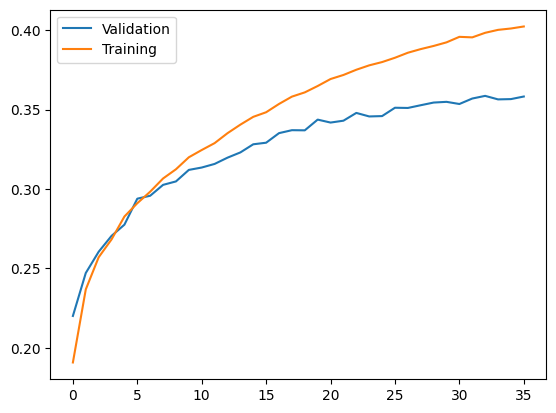

In [24]:
from matplotlib import pyplot as plt
epochs_ran=len(h.history['loss'])
plt.plot(range( 0,epochs_ran),h.history['val_accuracy'],label='Validation')
plt.plot(range( 0,epochs_ran),h.history['accuracy'],label='Training')
plt.legend()
plt

## Task 8: Generate Names!

In [29]:
def generate_names(seed):
  for i in range(0,40):
    seq=name_to_seq(seed)
    padded=tf.keras.preprocessing.sequence.pad_sequences([seq],padding='pre',maxlen=max_len-1,truncating='pre')
    pred=model.predict(padded)[0]
    pred_char=index_to_char[pred.argmax()]
    seed+=pred_char
    if pred_char=='\t':
      break
  print(seed)

In [30]:
generate_names('pi')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
pires marter	


In [31]:
generate_names('x')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
xena	


In [32]:
generate_names('a')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
arthar of the hellan	


In [33]:
generate_names('bu')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
burlice	
